In [8]:
%reset -f
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_curve, auc
from torch.utils.data import random_split, DataLoader
from sklearn.model_selection import train_test_split
#import wandb


from customDatasets.audioDataset import AudioDataset


In [9]:
# free gpu
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.LeakyReLU(0.2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, input_size),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
# test for deciding the mels parameters
from utils.audioUtils import AudioUtil
from torchaudio import transforms
import torch
audio_file = "./data/train/normal_id_00_00000000.wav"

aud = AudioUtil.open(audio_file)
sig, sr = aud
mel = transforms.MelSpectrogram(sr, n_fft=1000, hop_length=501, n_mels=128)
spec = mel(sig)
ampl = transforms.AmplitudeToDB(top_db=80)
spec = ampl(spec)


print(spec.shape)


torch.Size([1, 128, 320])


In [12]:
def train_model(model, train_dl, val_dl, test_dl, criterion, optimizer, device, wandb=None, epochs=5,step_size=5):
    lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)
    best_val_loss = np.inf
    for epoch in range(epochs):
        train_losses = []
        val_losses = []
        for inputs, labels in train_dl:
            model.train()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs.view(inputs.size(0), -1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        lr_scheduler.step()
        print(f'Epoch[{epoch + 1}/{epochs}], Train loss: {np.average(train_losses): .4f}')
        
        for inputs, labels in val_dl:
            model.eval()
            with torch.no_grad():
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.view(inputs.shape[0]*inputs.shape[1], -1)
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_losses.append(loss.item())
        print(f'Epoch[{epoch + 1}/{epochs}], Val loss: {np.average(val_losses): .4f}')
        if np.average(val_losses) < best_val_loss:
            best_val_loss = np.average(val_losses)
 
        full_scores = []
        full_labels = []
        for inputs, labels in test_dl:
            inputs, labels = inputs.to(CONFIG["device"]), labels.to(CONFIG["device"])
            model.eval()
            with torch.no_grad():
                tmp_scores = []
                for idx in range (10):
                    outputs = model(inputs[:, idx, :, :])
                    mse = torch.sum((outputs - inputs[:, idx, :, :].view(inputs.size(0), -1)) ** 2, dim=1, keepdim=True) / outputs.shape[1]
                    tmp_scores.append(mse)

                scores = torch.cat(tmp_scores, dim=1)
                scores = torch.max(scores, dim=1).values

                full_scores.append(scores)
                full_labels.append(labels)
        
        full_labels = torch.cat([label for label in full_labels])
        full_scores = torch.cat([score for score in full_scores])
        fpr, tpr, _ = roc_curve(full_labels.cpu().detach(), full_scores.cpu().detach(), pos_label=0)
        roc_auc = auc(fpr, tpr)
        print(roc_auc)
        if wandb:
            wandb.log({"roc_auc test": roc_auc, "val_loss": np.average(val_losses), "train_loss": np.average(train_losses)})
    return best_val_loss

In [13]:
def set_seed(seed = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

CONFIG = {
    "seed": 42,
    "epochs": 500,
    "num_classes": 2,
    "learning_rate": 0.001,
    "train_batch_size": 32,
    "val_batch_size": 16,
    "test_batch_size": 128,
    "criterion": nn.MSELoss(),
    "device":
        torch.device(
            "cuda:0" if torch.cuda.is_available()
            else "mps" if torch.backends.mps.is_available()
            else "cpu"
        )
}

set_seed(CONFIG['seed'])

data_path = "./data/train/"
data_path_test = "./data/test/"


meta_train_df = pd.read_csv("./data/train.csv")
meta_test_df = pd.read_csv("./data/test.csv")

train_df = meta_train_df[['filename', 'is_normal', 'machine_id']]
#range_train, range_test = train_test_split(range(len(train_df)), test_size=0.2, train_size=0.8, random_state=None, shuffle=True, stratify=meta_train_df['machine_id'])
#val_df = train_df.iloc[range_test].reset_index(drop=True)
# create an empty df
val_df = pd.DataFrame(columns=['filename', 'is_normal', 'machine_id'])
#train_df = train_df.iloc[range_train].reset_index(drop=True)
train_df = train_df
train_dataset = AudioDataset(train_df, data_path,in_memory=True, sgram_type="mel", augment=True, split_sgram=True)
val_dataset = AudioDataset(val_df, data_path,in_memory=True, sgram_type="mel", augment=False, test_mode=True)
test_df = meta_test_df[['filename', 'is_normal', 'machine_id']]
test_dataset = AudioDataset(test_df, data_path_test, in_memory=True, sgram_type="mel", augment=False, test_mode=True)

train_ds = train_dataset
val_ds = val_dataset
test_ds = test_dataset

train_dl = DataLoader(train_ds, batch_size=CONFIG['train_batch_size'], shuffle=True)
val_dl = DataLoader(val_ds, batch_size=CONFIG['val_batch_size'], shuffle=False)
test_dl = DataLoader(test_ds, batch_size=CONFIG["test_batch_size"], shuffle=False)

In [14]:
inputs, labels = next(iter(train_dl))

print(inputs.shape)

torch.Size([32, 1, 32, 128])


In [15]:
input_size = next(iter(train_dl))[0].shape[1] * next(iter(train_dl))[0].shape[2] * next(iter(train_dl))[0].shape[3]
model = Autoencoder(input_size, encoding_dim=128)
model = model.to(CONFIG["device"])
optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=1e-5)

In [16]:
# compute metrics
inputs_cat=[]
train_dataset.test_mode = True
for inputs, labels in train_dl:
    inputs_cat.append(inputs)
inputs_cat = torch.cat([input for input in inputs_cat])
inputs_cat = inputs_cat.view(-1,inputs_cat.shape[2],inputs_cat.shape[3])
print(inputs_cat.shape)
train_dataset.test_mode = False

torch.Size([23700, 32, 128])


In [17]:
mean = torch.mean(inputs_cat, dim=0)
std = torch.std(inputs_cat, dim=0)
print(mean.shape)
print(std.shape)
train_dataset.mean = mean
train_dataset.std = std
val_dataset.mean = mean
val_dataset.std = std
test_dataset.mean = mean
test_dataset.std = std

torch.Size([32, 128])
torch.Size([32, 128])


In [18]:
# init wandb
#wandb.login()

In [19]:
# start a new wandb run to track this script
#wandb.init(
#    # set the wandb project where this run will be logged
#    project="Challenge_2_AETimeFrames",
#)
# save all the parameters from the CONFIG dict
#wandb.config.update(CONFIG)
#print(wandb.config)

In [20]:
training=True
input_size = next(iter(train_dl))[0].shape[1] * next(iter(train_dl))[0].shape[2] * next(iter(train_dl))[0].shape[3]
grid_search=False
measures=[1,0,1,1,1]
# testing emb space size
if training and grid_search :
    measures=[]
    for emb_space_size in [32, 64, 128, 256, 512]:
        model = Autoencoder(encoding_dim=emb_space_size, input_size=input_size)
        model = model.to(CONFIG["device"])
        optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"])
        measures.append(train_model(model, train_dl, val_dl, test_dl, CONFIG["criterion"], optimizer, CONFIG["device"], epochs=50))

In [21]:
if training:
    emb_spaces=[32, 64, 128, 256, 512]
    for emb_space_size, measure in zip(emb_spaces, measures):
        print(f"Emb space size: {emb_space_size}, Train loss: {measure}")
    print(f"Best emb space size: {emb_spaces[np.argmin([measure for measure in measures])]}")

Emb space size: 32, Train loss: 1
Emb space size: 64, Train loss: 0
Emb space size: 128, Train loss: 1
Emb space size: 256, Train loss: 1
Emb space size: 512, Train loss: 1
Best emb space size: 64


In [22]:
print(measures)

[1, 0, 1, 1, 1]


In [23]:
# take the best one and train it for more epochs
if training:
    emb_space_measures=[32, 64, 128, 256, 512]
    model = Autoencoder(encoding_dim=128, input_size=input_size)
    model = model.to(CONFIG["device"])
    optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"])

In [25]:
training=True
if training:
    train_model(model, train_dl, val_dl, test_dl, CONFIG["criterion"], optimizer, CONFIG["device"], None, CONFIG["epochs"], 50)

Epoch[326/500], Train loss:  0.3669
Epoch[326/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8473907615480649
Epoch[327/500], Train loss:  0.3757
Epoch[327/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8677403245942572
Epoch[328/500], Train loss:  0.3658
Epoch[328/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.861918435289222
Epoch[329/500], Train loss:  0.3678
Epoch[329/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.833491468997087
Epoch[330/500], Train loss:  0.3651
Epoch[330/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8329754473574698
Epoch[331/500], Train loss:  0.3698
Epoch[331/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8410278818143987
Epoch[332/500], Train loss:  0.3656
Epoch[332/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8416687473990845
Epoch[333/500], Train loss:  0.3673
Epoch[333/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8330004161464837
Epoch[334/500], Train loss:  0.3691
Epoch[334/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8412692467748647
Epoch[335/500], Train loss:  0.3803
Epoch[335/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8717894298793174
Epoch[336/500], Train loss:  0.3650
Epoch[336/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8421722846441948
Epoch[337/500], Train loss:  0.3640
Epoch[337/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8276404494382024
Epoch[338/500], Train loss:  0.3698
Epoch[338/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8548272992093218
Epoch[339/500], Train loss:  0.3610
Epoch[339/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8572742405326674
Epoch[340/500], Train loss:  0.3674
Epoch[340/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8401789429879318
Epoch[341/500], Train loss:  0.3760
Epoch[341/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.827852684144819
Epoch[342/500], Train loss:  0.3688
Epoch[342/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8470536828963796
Epoch[343/500], Train loss:  0.3703
Epoch[343/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8293008739076155
Epoch[344/500], Train loss:  0.3659
Epoch[344/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.844415314190595
Epoch[345/500], Train loss:  0.3672
Epoch[345/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8553058676654183
Epoch[346/500], Train loss:  0.3658
Epoch[346/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8400707449022056
Epoch[347/500], Train loss:  0.3647
Epoch[347/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8506034124011653
Epoch[348/500], Train loss:  0.3689
Epoch[348/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8366167290886393
Epoch[349/500], Train loss:  0.3719
Epoch[349/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8301165210153973
Epoch[350/500], Train loss:  0.3626
Epoch[350/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8543695380774032
Epoch[351/500], Train loss:  0.3603
Epoch[351/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8587265917602998
Epoch[352/500], Train loss:  0.3691
Epoch[352/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.86284228048273
Epoch[353/500], Train loss:  0.3718
Epoch[353/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8622513524760715
Epoch[354/500], Train loss:  0.3675
Epoch[354/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.840353724511028
Epoch[355/500], Train loss:  0.3692
Epoch[355/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8452933832709114
Epoch[356/500], Train loss:  0.3680
Epoch[356/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8293300041614649
Epoch[357/500], Train loss:  0.3641
Epoch[357/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8459633791094466
Epoch[358/500], Train loss:  0.3688
Epoch[358/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.864956304619226
Epoch[359/500], Train loss:  0.3656
Epoch[359/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8498709945900957
Epoch[360/500], Train loss:  0.3643
Epoch[360/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8513732833957552
Epoch[361/500], Train loss:  0.3660
Epoch[361/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8515813566375363
Epoch[362/500], Train loss:  0.3659
Epoch[362/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8353308364544318
Epoch[363/500], Train loss:  0.3695
Epoch[363/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8257428214731585
Epoch[364/500], Train loss:  0.3684
Epoch[364/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8609280066583438
Epoch[365/500], Train loss:  0.3647
Epoch[365/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8590470245526427
Epoch[366/500], Train loss:  0.3643
Epoch[366/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8338784852267997
Epoch[367/500], Train loss:  0.3704
Epoch[367/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8399126092384519
Epoch[368/500], Train loss:  0.3655
Epoch[368/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8655867665418225
Epoch[369/500], Train loss:  0.3737
Epoch[369/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8566208905534748
Epoch[370/500], Train loss:  0.3648
Epoch[370/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8442863087806909
Epoch[371/500], Train loss:  0.3737
Epoch[371/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8565251768622555
Epoch[372/500], Train loss:  0.3696
Epoch[372/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8443820224719101
Epoch[373/500], Train loss:  0.3662
Epoch[373/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8415022888056596
Epoch[374/500], Train loss:  0.3704
Epoch[374/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8301498127340824
Epoch[375/500], Train loss:  0.3669
Epoch[375/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8618352059925094
Epoch[376/500], Train loss:  0.3712
Epoch[376/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.856695796920516
Epoch[377/500], Train loss:  0.3698
Epoch[377/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8629879317519766
Epoch[378/500], Train loss:  0.3695
Epoch[378/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8163171036204744
Epoch[379/500], Train loss:  0.3674
Epoch[379/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8667207657095298
Epoch[380/500], Train loss:  0.3622
Epoch[380/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8444569288389512
Epoch[381/500], Train loss:  0.3682
Epoch[381/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.862201414898044
Epoch[382/500], Train loss:  0.3675
Epoch[382/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8475780274656679
Epoch[383/500], Train loss:  0.3677
Epoch[383/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8635455680399501
Epoch[384/500], Train loss:  0.3663
Epoch[384/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8516645859342488
Epoch[385/500], Train loss:  0.3732
Epoch[385/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8181689554723263
Epoch[386/500], Train loss:  0.3642
Epoch[386/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8593591344153142
Epoch[387/500], Train loss:  0.3653
Epoch[387/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8483062838119019
Epoch[388/500], Train loss:  0.3648
Epoch[388/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8392883895131086
Epoch[389/500], Train loss:  0.3669
Epoch[389/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8331210986267167
Epoch[390/500], Train loss:  0.3651
Epoch[390/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8446109030378695
Epoch[391/500], Train loss:  0.3606
Epoch[391/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8532417811069497
Epoch[392/500], Train loss:  0.3779
Epoch[392/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8273366625052019
Epoch[393/500], Train loss:  0.3661
Epoch[393/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8415938410320433
Epoch[394/500], Train loss:  0.3645
Epoch[394/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8610819808572618
Epoch[395/500], Train loss:  0.3684
Epoch[395/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8325176862255514
Epoch[396/500], Train loss:  0.3646
Epoch[396/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8388014981273408
Epoch[397/500], Train loss:  0.3669
Epoch[397/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8442655014565128
Epoch[398/500], Train loss:  0.3620
Epoch[398/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8490595089471493
Epoch[399/500], Train loss:  0.3683
Epoch[399/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8599958385351645
Epoch[400/500], Train loss:  0.3621
Epoch[400/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8631294215563878
Epoch[401/500], Train loss:  0.3707
Epoch[401/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8473990844777363
Epoch[402/500], Train loss:  0.3631
Epoch[402/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8438535164377862
Epoch[403/500], Train loss:  0.3652
Epoch[403/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8671202663337496
Epoch[404/500], Train loss:  0.3660
Epoch[404/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8373033707865167
Epoch[405/500], Train loss:  0.3654
Epoch[405/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.855056179775281
Epoch[406/500], Train loss:  0.3627
Epoch[406/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.845726175613816
Epoch[407/500], Train loss:  0.3655
Epoch[407/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8373116937161881
Epoch[408/500], Train loss:  0.3693
Epoch[408/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8363462338743238
Epoch[409/500], Train loss:  0.3660
Epoch[409/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8548522679983355
Epoch[410/500], Train loss:  0.3635
Epoch[410/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8635289221806077
Epoch[411/500], Train loss:  0.3618
Epoch[411/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8359217644610903
Epoch[412/500], Train loss:  0.3636
Epoch[412/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8496837286724928
Epoch[413/500], Train loss:  0.3698
Epoch[413/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8260840615896796
Epoch[414/500], Train loss:  0.3704
Epoch[414/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8251893466500207
Epoch[415/500], Train loss:  0.3623
Epoch[415/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8458551810237204
Epoch[416/500], Train loss:  0.3642
Epoch[416/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.85749063670412
Epoch[417/500], Train loss:  0.3657
Epoch[417/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8497960882230545
Epoch[418/500], Train loss:  0.3852
Epoch[418/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8219850187265918
Epoch[419/500], Train loss:  0.3664
Epoch[419/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8547732001664585
Epoch[420/500], Train loss:  0.3704
Epoch[420/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8490428630878069
Epoch[421/500], Train loss:  0.3718
Epoch[421/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8297170203911777
Epoch[422/500], Train loss:  0.3675
Epoch[422/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8630878069080318
Epoch[423/500], Train loss:  0.3610
Epoch[423/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.839196837286725
Epoch[424/500], Train loss:  0.3646
Epoch[424/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.863116937161881
Epoch[425/500], Train loss:  0.3666
Epoch[425/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.859612983770287
Epoch[426/500], Train loss:  0.3637
Epoch[426/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8682064086558469
Epoch[427/500], Train loss:  0.3680
Epoch[427/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8616770703287556
Epoch[428/500], Train loss:  0.3668
Epoch[428/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8599750312109863
Epoch[429/500], Train loss:  0.3712
Epoch[429/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8239325842696629
Epoch[430/500], Train loss:  0.3716
Epoch[430/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.831310861423221
Epoch[431/500], Train loss:  0.3670
Epoch[431/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8573741156887225
Epoch[432/500], Train loss:  0.3666
Epoch[432/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8567041198501874
Epoch[433/500], Train loss:  0.3685
Epoch[433/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8388972118185601
Epoch[434/500], Train loss:  0.3640
Epoch[434/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8511111111111113
Epoch[435/500], Train loss:  0.3663
Epoch[435/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8490178942987932
Epoch[436/500], Train loss:  0.3643
Epoch[436/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8579234290470246
Epoch[437/500], Train loss:  0.3646
Epoch[437/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8537432376196421
Epoch[438/500], Train loss:  0.3636
Epoch[438/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8486974615064502
Epoch[439/500], Train loss:  0.3687
Epoch[439/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8240199750312109
Epoch[440/500], Train loss:  0.3680
Epoch[440/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8688514357053683
Epoch[441/500], Train loss:  0.3735
Epoch[441/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8621639617145235
Epoch[442/500], Train loss:  0.3730
Epoch[442/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8342238868081565
Epoch[443/500], Train loss:  0.3681
Epoch[443/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8443071161048689
Epoch[444/500], Train loss:  0.3636
Epoch[444/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8558052434456929
Epoch[445/500], Train loss:  0.3699
Epoch[445/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8359717020391177
Epoch[446/500], Train loss:  0.3646
Epoch[446/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8583478984602579
Epoch[447/500], Train loss:  0.3629
Epoch[447/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8422388680815648
Epoch[448/500], Train loss:  0.3684
Epoch[448/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8227132750728257
Epoch[449/500], Train loss:  0.3687
Epoch[449/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8490761548064919
Epoch[450/500], Train loss:  0.3665
Epoch[450/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8513691219309196
Epoch[451/500], Train loss:  0.3711
Epoch[451/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8670495214315439
Epoch[452/500], Train loss:  0.3638
Epoch[452/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8557469829379942
Epoch[453/500], Train loss:  0.3690
Epoch[453/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8485684560965459
Epoch[454/500], Train loss:  0.3691
Epoch[454/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8583270911360799
Epoch[455/500], Train loss:  0.3712
Epoch[455/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8432667498959634
Epoch[456/500], Train loss:  0.3687
Epoch[456/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8414606741573034
Epoch[457/500], Train loss:  0.3661
Epoch[457/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8603828547648772
Epoch[458/500], Train loss:  0.3610
Epoch[458/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8181564710778193
Epoch[459/500], Train loss:  0.3675
Epoch[459/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8409030378693301
Epoch[460/500], Train loss:  0.3682
Epoch[460/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8357261756138161
Epoch[461/500], Train loss:  0.3660
Epoch[461/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8662047440699127
Epoch[462/500], Train loss:  0.3634
Epoch[462/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8476570952975447
Epoch[463/500], Train loss:  0.3633
Epoch[463/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8601040366208905
Epoch[464/500], Train loss:  0.3685
Epoch[464/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8630420307948399
Epoch[465/500], Train loss:  0.3655
Epoch[465/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8338784852268001
Epoch[466/500], Train loss:  0.3676
Epoch[466/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8464960466084062
Epoch[467/500], Train loss:  0.3636
Epoch[467/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8375780274656678
Epoch[468/500], Train loss:  0.3682
Epoch[468/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8307865168539326
Epoch[469/500], Train loss:  0.3664
Epoch[469/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8472118185601333
Epoch[470/500], Train loss:  0.3662
Epoch[470/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8686433624635872
Epoch[471/500], Train loss:  0.3742
Epoch[471/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8637952559300875
Epoch[472/500], Train loss:  0.3652
Epoch[472/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8440740740740742
Epoch[473/500], Train loss:  0.3639
Epoch[473/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8432833957553059
Epoch[474/500], Train loss:  0.3660
Epoch[474/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8519184352892217
Epoch[475/500], Train loss:  0.3670
Epoch[475/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8412193091968374
Epoch[476/500], Train loss:  0.3737
Epoch[476/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8126799833541407
Epoch[477/500], Train loss:  0.3622
Epoch[477/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8512193091968372
Epoch[478/500], Train loss:  0.3705
Epoch[478/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8186475239284228
Epoch[479/500], Train loss:  0.3704
Epoch[479/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8634290470245527
Epoch[480/500], Train loss:  0.3677
Epoch[480/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8550561797752809
Epoch[481/500], Train loss:  0.3760
Epoch[481/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8298793175197671
Epoch[482/500], Train loss:  0.3647
Epoch[482/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8385601331668747
Epoch[483/500], Train loss:  0.3691
Epoch[483/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8446358718268832
Epoch[484/500], Train loss:  0.3655
Epoch[484/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8358302122347065
Epoch[485/500], Train loss:  0.3709
Epoch[485/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8659508947149396
Epoch[486/500], Train loss:  0.3676
Epoch[486/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8602163961714523
Epoch[487/500], Train loss:  0.3615
Epoch[487/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8461964211402414
Epoch[488/500], Train loss:  0.3643
Epoch[488/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8560549313358303
Epoch[489/500], Train loss:  0.3688
Epoch[489/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8518934665002081
Epoch[490/500], Train loss:  0.3671
Epoch[490/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8610029130253849
Epoch[491/500], Train loss:  0.3679
Epoch[491/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8562713275072825
Epoch[492/500], Train loss:  0.3646
Epoch[492/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8617311693716188
Epoch[493/500], Train loss:  0.3607
Epoch[493/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8362838119017894
Epoch[494/500], Train loss:  0.3747
Epoch[494/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8116812317935913
Epoch[495/500], Train loss:  0.3614
Epoch[495/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8485310029130255
Epoch[496/500], Train loss:  0.3725
Epoch[496/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8183270911360798
Epoch[497/500], Train loss:  0.3679
Epoch[497/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8441614648356222
Epoch[498/500], Train loss:  0.3719
Epoch[498/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8213857677902621
Epoch[499/500], Train loss:  0.3745
Epoch[499/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8266250520183104
Epoch[500/500], Train loss:  0.3673
Epoch[500/500], Val loss:  nan


/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.8549063670411985


In [ ]:
# mel , hz
measures_preproc_norm=[[0.45140895048777263, 0.4439425359169642, 0.44581543107827504, 0.444801339507103, 0.44873113334178927],[0.6853891452153523, 0.6844642202059428, 0.6859250048796336, 0.6872238258520762, 0.6908326943715414]]
measures_preproc_minmax=[[0.007311151052514712, 0.007400488651668032, 0.0072833825057993335, 0.0072919094314177835, 0.007430297431225578],[0.008575264737010002, 0.00845122483248512, 0.008532586103926102, 0.008576250479867062, 0.008573986434688171]]
emb_spaces=[32, 64, 128, 256, 512]
# train,val loss
losses_mel = [0.3685, 0.3972]

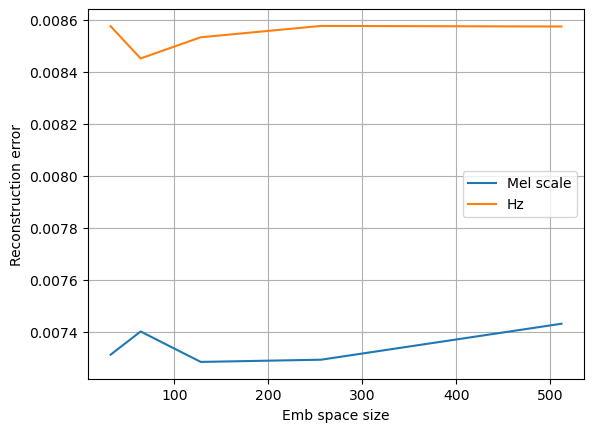

In [ ]:
import matplotlib.pyplot as plt
mel = [0.007311151052514712, 0.007400488651668032, 0.0072833825057993335, 0.0072919094314177835, 0.007430297431225578]
hz = [0.008575264737010002, 0.00845122483248512, 0.008532586103926102, 0.008576250479867062, 0.008573986434688171]
#plot the losses with respect to emb space size
emb_spaces=[32, 64, 128, 256, 512]
plt.plot(emb_spaces, mel, label="Mel scale")
plt.plot(emb_spaces, hz, label="Hz")
plt.legend()
plt.xlabel("Emb space size")
plt.ylabel("Reconstruction error")
plt.grid()
plt.show()